#  CMSC 491: Data Science Project 

### Contributors:  Joshua Standiford; Dan Kelly; Malik Jackson

This project is about analyzing weather patterns in baltimore and an increase in domestic crime.  The his project is about analyzing weather patterns in baltimore and determining if there's an increase in domestic crime. The jupyter notebook will analyze the crime and weather data for Baltimore, MD. From the notebook, visualizations of the crime data will be output and viewable on:
    http://hire-josh.com/projects/491proj/web/view/

This project runs on a python 2.7 kernel, for functionality otherwise limited by the python 3 kernel.
This project is available for viewing and download at https://github.com/linkvetern64/CMSC491/tree/develop 

## Hypothesis

### "Are domestic abuse and assault cases more likely to occur during cold or inclimate weather?"

We are defining "Cold" weather to be within the range of 45 degrees or less.


## Null Hypothesis

### "There's no correlation between cold or inclimate weather and an increase in domestic abuse or assault"




## HouseKeeping

Importing packages, loading data sets and creating data frames are localized at the start of the program. This makes it easy to make changes, without having to navigate through the page to look for dependencies.

In [3]:
#Malik Jackson 491 Data Science
from IPython.display import IFrame
from sklearn.svm import SVC
from sklearn.svm import LinearSVC 
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn import  model_selection,metrics
import pandas as pd
import random
import inspect
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import scipy
from scipy import stats
import re

#if the csv and xlsx files are not in the same directory, use pandas.read_excel('path/to/direct/filename.txt')
weather = pandas.read_excel('Baltimore_Weather_Data_3_Yr_Pnds_Adjst.xlsx')
df1 = pandas.read_csv('Calls_for_Disorderly.csv')
df2 = pandas.read_csv('Calls_for_Common_Assault.csv')
df3 = pandas.read_csv('Calls_for_Family_Disturb.csv')
df4 = pandas.read_csv('Calls_for_Behavioral_Crisis.csv')

#weather = pandas.read_excel('../data/Baltimore_Weather_Data_3_Yr_Pnds_Adjst.xlsx')
#df1 = pandas.read_csv('../data/Calls_for_Disorderly.csv')
#df2 = pandas.read_csv('../data/Calls_for_Common_Assault.csv')
#df3 = pandas.read_csv('../data/Calls_for_Family_Disturb.csv')
#df4 = pandas.read_csv('../data/Calls_for_Behavioral_Crisis.csv')

crime  = pandas.concat([df1,df2,df3,df4])

## Pre-processing 

We start by eliminating incomplete data. We'll drop any fields with empty locations, since we need those for our heatmap

In [4]:
crime = crime.dropna(subset = ['location'])

## Creating New Attributes & Columns

Now let's do preprocessing by stripping the long-lat coordinates from the location and throwing them into their own field. If no coordinate data is given, we can denote that in the column with a zero

In [5]:
trueLoc = []
for locs in crime['location']:
    if type(locs) == str:
        coords = (re.findall(r'[+-]?[0-9.]+', locs))
        if len(coords) >= 2:
            trueLoc.append( [float(coords[-2]), float(coords[-1])])
        else:
            trueLoc.append(0)
    else:
        trueLoc.append(0)
        
crime['Coordinates'] = trueLoc

## Noise Reduction
Now we just drop all rows where we denoted zeroes. We should only expect to find zeroes in the locations column where we
denoted them for incompletel locations, but if any other cell only has a zero, that means some additional information is missing and it's best to check and eliminate that now, then to run into errors later.

In [6]:
crime = crime[(crime != 0).all(1)]

## Normalize data

Below we are normalizing the data, so the values match the same case. This is also to prevent any data that should match, that otherwise wouldn't. For example, ASSAULT and Assault are equal. However they would generate a seperate column which isn't preffered.

In [7]:
#Some data in the description has the same names differentiated by case. let's normalize this
names = []
for type in crime['description']:
    names.append(type.upper())
crime['description'] = names

## Value Encoding
To make processing the crimes easier, instead of going by their names we will encode them. We are using a method known as label-assignment. Below that we are also formatting the weather and crime date's and times. We are joining the weather and crime data by the date. This way we can ensure from the top that the date's will match so the fuse will occur error free.

In [8]:
#Now we'll encode our data so we have our four basic types BEHAVIORAL_CRISIS:0 COMMON ASSAULT:1 DISORDERLY:2 FAMILY_DISTURB:3  
#crime["description"] 
print crime["description"].unique()
print (crime["description"].astype('category').cat.codes).unique()

crime["description"] = crime["description"].astype('category').cat.codes

['DISORDERLY' 'COMMON ASSAULT' 'FAMILY DISTURB' 'BEHAVIOR CRISIS']
[2 1 3 0]


In [9]:
#Let's encode our dates into a proper date format in both our crime and weather pandas
dates = []
for a in  crime.as_matrix():
    dates.append( datetime.strptime(a[0].split(" ")[0] , '%m/%d/%Y'))
crime['callDateTime'] = dates

dates = []
for a in  weather.as_matrix():
    dates.append( datetime.strptime(a[0] , '%m/%d/%Y'))
weather['Date'] = dates

## Sorting
We are sorting the entries by date and time, so they are logically displayed in the data frames.

In [10]:
#Now, we'll sort our crimes by date in order to add in a temperature for each day
crime =  crime.sort_values(['callDateTime'], ascending=True)
crime = crime[0:386800]

## Averaging Temperature
Below we are match the average value of our weather conditions to our crime incidences based on the date of their occurence.

In [11]:
#Find corresponding temperatures for each crime report day and add that column back in. For our correlation analysis
#we'll just use the average temperature of our dataset. We'll use the other weather statistics for our classification
avgWeather = []
avgDew  = []
AvgHum = []
AvgSLP = []
AvgW = []
AvgVis = []
Precip = []
Events = []
indx = 0 
for a in crime['callDateTime']:
    while a !=  weather['Date'][indx]:
        indx += 1
    avgWeather.append(weather['Avg_Temp'][indx])
    avgDew.append(weather['Avg_Dew_Point'][indx])
    AvgHum.append(weather['Avg_Humidity'][indx])
    AvgSLP.append(weather['Avg_Sea_Level_Pressure'][indx])
    AvgVis.append(weather['Avg_Visibility'][indx])
    AvgW.append(weather['Avg_Wind'][indx])
    Precip.append(weather['Precip'][indx])
    Events.append(weather['Events'][indx])
    
crime['Avg_Temp'] = avgWeather
crime['Avg_Dew_Point'] = avgDew
crime['Avg_Humidity'] = AvgHum
crime['Avg_Sea_Level_Pressure'] = AvgSLP
crime['Avg_Visibility'] = AvgVis
crime['Avg_Wind'] = AvgW
crime['Precip'] = Precip
crime['Events'] = Events

## Visualization 

Our visualization and analysis of results will help us determine our correlation

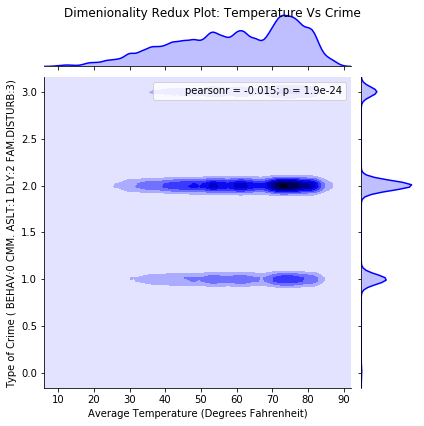

In [59]:
#Let's see visualization of our factors now. First, we'll use a dimensionality reduction plot to see the relative amount of
#crimes per temperature
g = sns.jointplot(x=crime['Avg_Temp'], y=crime['description'], kind="kde", color="Blue")
g.set_axis_labels("Average Temperature (Degrees Fahrenheit)", "Type of Crime \
( BEHAV:0 CMM. ASLT:1 DLY:2 FAM.DISTURB:3) ")
g.fig.suptitle('Dimenionality Redux Plot: Temperature Vs Crime')
plt.show()
g.savefig("Dimenionality Plot Weather and Crime.png")

### PDA

Analysis:
Above is a dimensionally reduced visualization of the data for crime's and temperature. An analysis of this visual depicts that of all crimes that occur, Disorderly Conduct appears to be the most common crime to occur. The weight of the distribution tends to be towards hotter temperatures as well. We actually see this trend among all the crimes listed in the dimensionality reduction. This does not validate our hypothesis that adverse weather increases violent crime, otherwise we would see a higher distribution as the temperature got colder. an important note here is the relative amount of behavioral crises calls (y= 0). This is an important sidenote perhapsgiving insight into the relative visiibility of mental health and behavior disorders in Baltimore

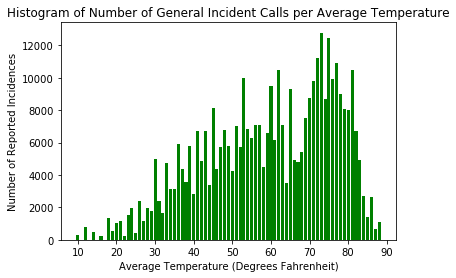

In [19]:
#Next, Let's use Histograms to get another visualiztion that will help see our correlation
#We'll start by getting counts of all incidents of crime at each  average temperature
tempBook = {}
for a in weather['Avg_Temp'].unique():
    tempBook[a] = 0
    
for a in crime['Avg_Temp']:
    tempBook[a] += 1
    
#Now, let's graph our histogram
plt.bar(tempBook.keys(), tempBook.values(),color='g')
plt.ylabel('Number of Reported Incidences')
plt.xlabel("Average Temperature (Degrees Fahrenheit)")
plt.title("Histogram of Number of General Incident Calls per Average Temperature")
plt.show()

## Incident Analysis

From the distribution featuring all of our types of crimes  above, we can see that the distribution is bimodal. This indicates that a high grouping of people commit crimes, when its roughly 55 degrees and when its roughly 75 degrees.
This graph however does not show the trend that we're looking for, and that is if our hypothesis is true then we can expect a modal distribution that's skewed to the left. That would be an ideal distribution for our hypothesis because then we would see that the colder it got, the more crime increased. This is not the case, therefore this does not corraborate our hypothesis. The next following graphs looking at the distribution of each type of crime by temperature all show the same trend of crimes tend to happen more in warmer weather.

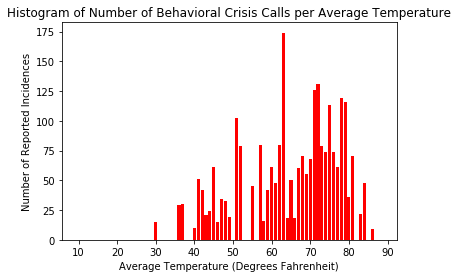

In [12]:
#Now let's see a break down of each type of crime by temperature. First, Behaviorial Crises (Notice the lack of calls
#as an important take away, mentioned above)
tempBook = {}
for a in weather['Avg_Temp'].unique():
    tempBook[a] = 0
    
for a,b in zip (crime['Avg_Temp'], crime['description']):
    if b == 0:
        tempBook[a] += 1
    
#Now, let's graph our histogram
plt.bar(tempBook.keys(), tempBook.values(),color='r')
plt.ylabel('Number of Reported Incidences')
plt.xlabel("Average Temperature (Degrees Fahrenheit)")
plt.title("Histogram of Number of Behavioral Crisis Calls per Average Temperature")
plt.show()

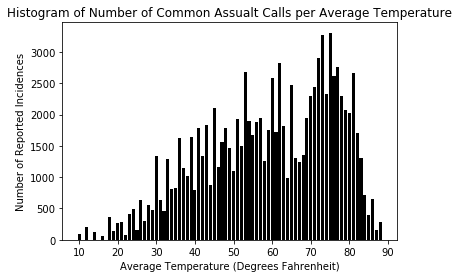

In [21]:
#Then, Common Assualt
tempBook = {}
for a in weather['Avg_Temp'].unique():
    tempBook[a] = 0
    
for a,b in zip (crime['Avg_Temp'], crime['description']) :
    if b == 1:
        tempBook[a] += 1
    
#Now, let's graph our histogram
plt.bar(tempBook.keys(), tempBook.values(),color='k') 
plt.ylabel('Number of Reported Incidences')
plt.xlabel("Average Temperature (Degrees Fahrenheit)")
plt.title("Histogram of Number of Common Assualt Calls per Average Temperature")
plt.show()

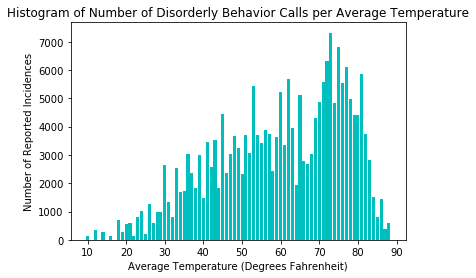

In [22]:
#Next, Disorderly Behavior
tempBook = {}
for a in weather['Avg_Temp'].unique():
    tempBook[a] = 0
    
for a,b in zip (crime['Avg_Temp'], crime['description']) :
    if b == 2:
        tempBook[a] += 1
    
#Now, let's graph our histogram
plt.bar(tempBook.keys(), tempBook.values(),color='c') 
plt.ylabel('Number of Reported Incidences')
plt.xlabel("Average Temperature (Degrees Fahrenheit)")
plt.title("Histogram of Number of Disorderly Behavior Calls per Average Temperature")
plt.show()

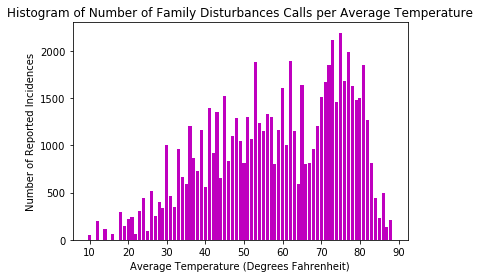

In [23]:
#Finally, Family Disturbances
tempBook = {}
for a in weather['Avg_Temp'].unique():
    tempBook[a] = 0
    
for a,b in zip (crime['Avg_Temp'], crime['description']) :
    if b == 3:
        tempBook[a] += 1
    
#Now, let's graph our histogram
plt.bar(tempBook.keys(), tempBook.values(),color='m') 
plt.ylabel('Number of Reported Incidences')
plt.xlabel("Average Temperature (Degrees Fahrenheit)")
plt.title("Histogram of Number of Family Disturbances Calls per Average Temperature")
plt.show()

## Correlation Conclusion

With suffienct data and a concrete correlation from our visualizzation, it's safe to say that we can reject the hypothesis that adverse weather conditions cause higher domestic crime in Baltimore.

# Classification 

Originally, we intended to find distinct correlations for some of the crimes. Using that, we wanted to be a able to attempt to classify types of crime, based on weather conditions. Unfortunantely, our conclusion found that all of the crimes correlated in the same manner. Despite this, we will proceed to demonstrate however that the data can be classified. We will look at a few classification algorithms like Linear Discriminant Analysis, Logistic Regression and K-Neighbors. Below we define a set of functions that Dr. Kalpaki's has generously allowed us to use. Since our correlations looked similr in nature, we should expect a classifier not to be able to distgingish between our crime types well.

In [10]:
#This project makes use of Dr Kalpakis' Classification notebook, so we'll use a lot of his functions he's defined.
def isOneOfMany(y):
    if y.ndim > 1 and y.shape[1] > 1:
        return True
    return False

def is_method(obj, name):
    val = False
    if hasattr(obj, name) and inspect.ismethod(getattr(obj, name)):
        val = True
    #print(obj, name, val)
    return val

def modelPredict(X_this, y_this, model):
    # y_hat, y_score, y_prob = modelPredict(X_this, y_this, model)
    y_hat = classifier.predict(X_this)
    y_score = np.zeros_like(y_this) #.fill(np.nan) 
    y_score = y_hat
    y_prob = np.zeros_like(y_this) #.fill(np.nan)
    y_prob = y_hat
    if is_method(model, 'decision_function'): 
        y_score = classifier.decision_function(X_this)
    if is_method(model, 'predict_proba'): 
        y_prob = classifier.predict_proba(X_this)
    return (y_hat, y_score, y_prob)

def classifierConfusionMatrix(y, y_hat, n_classes=2, class_labels=None, title=None, ax=None, cmap=plt.cm.Blues):
    # Construct and plot a multi-class confusion matrix; 
    # C[i,j] is the fraction of true class i predicted as class j
    
    if class_labels is None:
        class_labels = ['Class ' + str(i) for i in range(n_classes)]
        
    #Compute confusion matrix and then normalize it (row-wise)
    if isOneOfMany(y):
        cm = metrics.confusion_matrix(y.argmax(1), y_hat.argmax(1))
    else:
        cm = metrics.confusion_matrix(y, y_hat)
        
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm = pd.DataFrame(cm, columns=class_labels, index=class_labels)
    #print("Normalized Confusion matrix\n", cm)
    
    if class_labels is None:
        class_labels = ['Class ' + str(i) for i in range(n_classes)]
    
    if ax is None:
        fig = plt.figure()
        ax = plt.gca()
    
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=True, yticklabels=True, cmap=cmap, ax=ax)
    ax.set_xlabel('Predicted class')
    ax.set_ylabel('True class')
    ax.set_title('Confusion Matrix [%s]' % title)
    
def plot1classROC(y, y_score, title='', ax=None):
    # assumes a binary classification problem, eg y is a single column array of 0 and 1's
    fpr, tpr, _ = metrics.roc_curve(y, y_score)
    roc_auc = metrics.auc(fpr, tpr)
    lw = 1
    if ax is None:
        plt.figure(figsize=(10, 8))
        ax = plt.gca()
        
    ax.plot(fpr, tpr, color='darkgreen', lw=1, label='ROC (auc = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")
    ax.set_title('ROC [%s]' % title)
    
def plotMultiClassROC(y, y_score, n_classes, title='', lw=1, ax=None, class_labels=None):
    # Compute macro-average ROC curve and ROC area for a multi-class classification where
    # y (and y_hat and y_score) is OneHot encoded eg it has n_classes columns 
    
    from scipy import interp
    from itertools import cycle
    
    if class_labels is None:
        class_labels = ['Class ' + str(i) for i in range(n_classes)]
        
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()   
    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(y[:, i], y_score[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    #y = pandas.get_dummies(y)
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y.ravel(), y_score.ravel())
    roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])
    
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])

    if ax is None:
        fig = plt.figure(figsize=(10, 8));
        ax = plt.gca()
        
    if class_labels is None:
        class_labels = ['class %d' % i for i in range(n_classes)]
        
    # Plot all ROC curves
    ax.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

    ax.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        label = class_labels[i]
        ax.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (auc = {1:0.2f})'
             ''.format(label, roc_auc[i]))

    ax.plot([0, 1], [0, 1], 'k--', lw=lw)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC [%s]' % title)
    ax.legend(loc="lower right")

def classifierPerformance(y, y_hat, y_score, n_classes=2, class_labels=None, title=None, ax=None):
    
    if class_labels is None:
        class_labels = ['Class ' + str(i) for i in range(n_classes)]
        
    print('Classification Report [%s]' % title)
    print(metrics.classification_report(y, y_hat, target_names=class_labels))

    print('Accuracy score= %.4f' % metrics.accuracy_score(y, y_hat))
    if isOneOfMany(y):
        ck = metrics.cohen_kappa_score(y.argmax(1), y_hat.argmax(1))
    else:
        ck = metrics.cohen_kappa_score(y, y_hat)
    
    print("Cohen's Kappa score= %.4f" % ck)
    
    classifierConfusionMatrix(y, y_hat, n_classes=n_classes, class_labels=class_labels, title=title)
    if n_classes == 2:
        plot1classROC(y, y_score, title=title, ax=ax)
    
    if n_classes > 2:
        plotMultiClassROC(y, y_score, n_classes, title=title, class_labels=class_labels, ax=ax)

## Classification Pre-Processing

We'll prepare our class and predictor set for training, eleminating non-numeric data and removing irrelevant data from our  predictors set.

In [11]:
# The dataset
X = crime.copy()
del X["description"]
del X["priority"]
del X["callNumber"]
del X["callDateTime"]
del X["incidentLocation"]
del X["location"]
del X["Coordinates"]
del X["Events"]
del X["district"]

In [12]:
predictors = []

y1 = crime["description"]

n_classes1 = len(crime['description'].unique())
class1_vals = crime['description'].unique()
#class1_labels = [ 'Class 1 Label: %d' % i for i in range(n_classes1)]
class1_labels = ['BEHAVIORAL_CRISIS','COMMON ASSAULT','DISORDERLY','FAMILY_DISTURB' ]
#BEHAVIORAL_CRISIS:0 COMMON ASSAULT:1 DISORDERLY:2 FAMILY_DISTURB:3  
print class1_vals
print class1_labels
#In class labels: BEHAVIORAL_CRISIS:Class 1 Label: 3
#COMMON ASSAULT:Class 1 Label: 2
#DISORDERLY:2 Class 1 Label: 0
#FAMILY_DISTURB:3  Class 1 Label: 1

[2 3 1 0]
['BEHAVIORAL_CRISIS', 'COMMON ASSAULT', 'DISORDERLY', 'FAMILY_DISTURB']


In [13]:
#For classification, We'll need every value to be numeric. Let's convert trace amounts in snow precip tot its definition amount
#.005 
precip = []
for a in X['Precip'].as_matrix():
    if  a == "T" :
        precip.append(.005)
    else:
        precip.append(a)
X['Precip'] = precip

## LDA Classification

Classification Report [Testing]


C:\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                   precision    recall  f1-score   support

BEHAVIORAL_CRISIS       0.00      0.00      0.00      1272
   COMMON ASSAULT       0.00      0.00      0.00     51177
       DISORDERLY       0.55      1.00      0.71    105628
   FAMILY_DISTURB       0.00      0.00      0.00     35323

      avg / total       0.30      0.55      0.39    193400

Accuracy score= 0.5462
Cohen's Kappa score= 83.9007


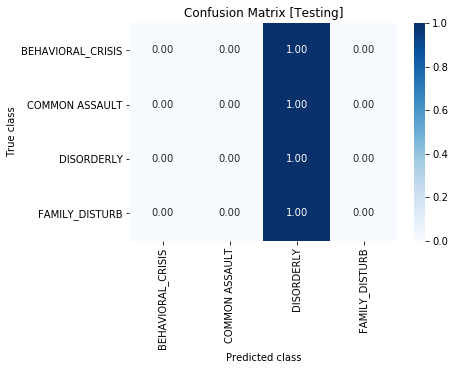

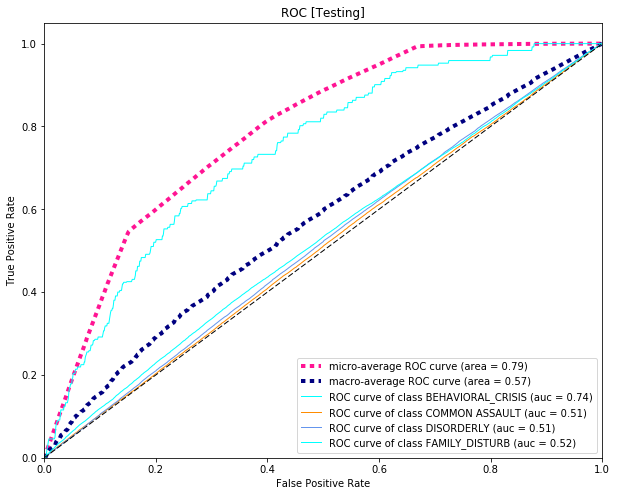

In [14]:
%matplotlib inline
model = LinearDiscriminantAnalysis()
classifier = OneVsRestClassifier(model)

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X.as_matrix(),  pandas.get_dummies(y1).as_matrix(), test_size=.5, random_state=0)

# fit the classifier to the training set

classifier1 = classifier.fit(X_train, y_train).decision_function(X_test)

y_hat, y_score, y_prob = modelPredict(X_test, y_test, model)

classifierPerformance(y_test, y_hat, y_score, n_classes1, class_labels=class1_labels, title='Testing')

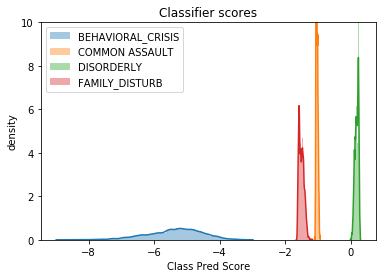

In [15]:
for i in range(n_classes1): 
    ax = sns.distplot(y_score[:,i], hist=True, kde=True, rug=False, norm_hist=True, label=class1_labels[i])    
ax.set_title('Classifier scores')
ax.set_xlabel('Class Pred Score')
ax.set_ylabel('density')
ax.set_ylim([0,10])
ax.legend() 

## Random Forest

Classification Report [Testing]
                   precision    recall  f1-score   support

BEHAVIORAL_CRISIS       0.00      0.00      0.00      1272
   COMMON ASSAULT       0.00      0.00      0.00     51177
       DISORDERLY       0.55      1.00      0.71    105628
   FAMILY_DISTURB       0.00      0.00      0.00     35323

      avg / total       0.30      0.55      0.39    193400

Accuracy score= 0.5462
Cohen's Kappa score= 83.9007


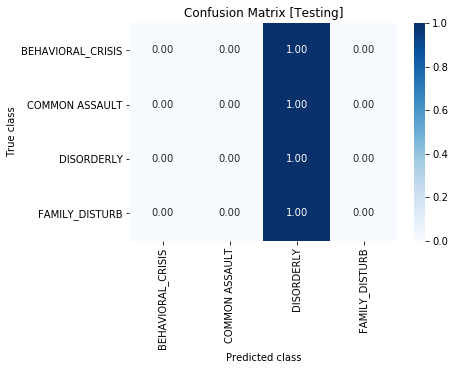

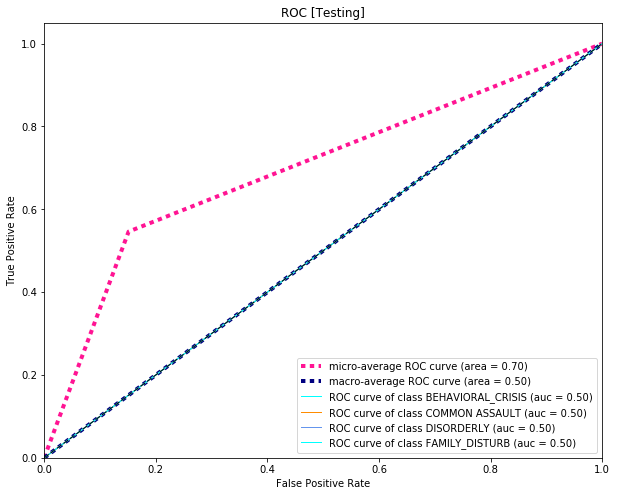

In [17]:

model = RandomForestClassifier(max_depth=2)
classifier = OneVsRestClassifier(model)

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X.as_matrix(),  pandas.get_dummies(y1).as_matrix(), test_size=.5, random_state=0)

# fit the classifier to the training set

classifier1 = classifier.fit(X_train, y_train).predict_proba(X_test)

y_hat, y_score, y_prob = modelPredict(X_test, y_test, model)

classifierPerformance(y_test, y_hat, y_score, n_classes1, class_labels=class1_labels, title='Testing')

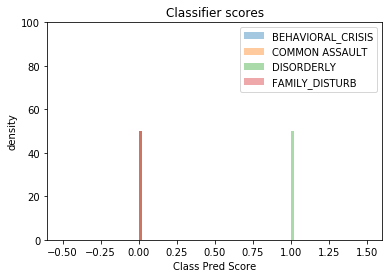

In [19]:
for i in range(n_classes1): 
    ax = sns.distplot(y_score[:,i], hist=True, kde=True, rug=False, norm_hist=True, label=class1_labels[i])    
ax.set_title('Classifier scores')
ax.set_xlabel('Class Pred Score')
ax.set_ylabel('density')
ax.set_ylim([0,100])
ax.legend() 

## Classification Results

As expected, our Classficiations model performed poorly and were not able to distguinsh between our types of crimes well, matching the trend of our correlations. To end this project we will perform a chi squared test below, formally disproving our hypothesis by having a p value lower then our alpha: we choose alpha = .05

## Chi Squared

In [62]:
contingency = pd.crosstab(crime['Avg_Temp'], crime['description'] )
alpha = .05
results =  stats.chi2_contingency(contingency)

print results[1]
print alpha > results[1]

0.0
True


Thus, we have formally disproved our hypothesis as our results have already done. We are still left with our important findings that general crimes seem to increase during the summer and significantly decrease in the winter. Given the size of our sample set, these results are significant enough to suggest further investigation.